In [1]:
# define imports 
import os
import random
import pickle 
import shutil
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine, euclidean

# import scikit-learn modules  
from sklearn.metrics import roc_curve, auc, precision_recall_curve, \
    average_precision_score, pairwise_distances

# import signaturizer module 
from signaturizer import Signaturizer
# import gensim library 
from gensim.models import KeyedVectors

# import plotting libraries 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
# seed the global RNG 
random.seed(SEED)
# seed the global NumPy RNG
np.random.seed(SEED)

### APDB embeddings vs CC signatures

1. Compute background distances
- https://gitlabsbnb.irbbarcelona.org/packages/chemical_checker/-/blob/master/package/chemicalchecker/core/signature_data.py

In [3]:
def compute_distance_pvalues(matrix, metric, sample_pairs=None, 
                             unflat=True, seed=SEED):
    
    """This function computes distance pvalues according to 
    the selected metric.

    :param matrix: a matrix of (n_samples, n_features) from which to 
        calculate distances
    :param metric: the metric name (cosine or euclidean)
    :param sample_pairs: amount of pairs for distance calculation
    :param unflat: whether to remove flat regions whenever we observe them
    :param seed: seed for reproducibility 
    :return: a dictionary with distances and pvalues 
    """

    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)

    # set metric function
    if metric not in ['cosine', 'euclidean']:
        raise Exception("Specified metric %s not available." % metric)
    metric_fn = eval(metric)
    
    # how many molecules give a proper sampling?
    if sample_pairs is None:
        # p and q are fixed parameters
        p, q = 0.5, 0.5
        # 5% confidence, 95% precision
        d, Z = 0.05, 1.96
        coef = Z**2 * p * q
        k = (coef * matrix.shape[0]) / (d**2 * (matrix.shape[0] - 1) + coef)
        sample_pairs = int(np.ceil(k**2))
    print("Background distances sample_pairs: %s" % sample_pairs)
    if matrix.shape[0]**2 < sample_pairs:
        print("Requested more pairs then possible combinations")
        sample_pairs = matrix.shape[0]**2 - matrix.shape[0]
    bg = list()
    done = set()
    tries = 1e6
    tr = 0
    identical = 0
    nan = 0
    while len(bg) < sample_pairs and tr < tries:
        tr += 1
        i = np.random.randint(0, matrix.shape[0] - 1)
        j = np.random.randint(i + 1, matrix.shape[0])
        if (i, j) not in done:
            dist = metric_fn(matrix[i], matrix[j])
            if dist == 0.0:
                identical += 1
                continue
            if np.isnan(dist):
                nan += 1
                continue
            bg.append(dist)
            done.add((i, j))
        if identical > 10000:
            print("Identical signatures for 1000 pairs")
            identical = 0
        if nan > 10000:
            print("NaN distances for 1000 pairs")
            nan = 0
            
    # pvalues as percentiles
    i = 0
    PVALS = [(0, 0., i)]  # DISTANCE, RANK, INTEGER
    PVALRANGES = np.array([0, 0.001, 0.01, 0.1] + list(np.arange(1, 100)) + [100]) / 100.
    i += 1
    percs = PVALRANGES[1:-1] * 100
    for perc in percs:
        PVALS += [(np.percentile(bg, perc), perc / 100., i)]
        i += 1
    PVALS += [(np.max(bg), 1., i)]
    
    # prepare returned dictionary
    bg_distances = dict()
    if not unflat:
        bg_distances["distance"] = np.array([p[0] for p in PVALS])
        bg_distances["pvalue"] = np.array([p[1] for p in PVALS])
    else:
        # remove flat regions whenever we observe them
        dists = [p[0] for p in PVALS]
        pvals = np.array([p[1] for p in PVALS])
        top_pval = np.min(
            [1. / sample_pairs, np.min(pvals[pvals > 0]) / 10.])
        pvals[pvals == 0] = top_pval
        pvals = np.log10(pvals)
        dists_ = sorted(set(dists))
        pvals_ = [pvals[dists.index(d)] for d in dists_]
        dists = np.interp(pvals, pvals_, dists_)
        thrs = [(dists[t], PVALS[t][1], PVALS[t][2])
                for t in range(len(PVALS))]
        bg_distances["distance"] = np.array([p[0] for p in thrs])
        bg_distances["pvalue"] = np.array([p[1] for p in thrs])

    return bg_distances


2. Compute vector distances
- https://gitlabsbnb.irbbarcelona.org/packages/chemical_checker/-/blob/master/package/chemicalchecker/core/diagnostics.py

In [4]:
def _compute_dists(pairs, vectors, metric, seed=SEED):

    """This function computes distance between pairs of vectors according to 
    the selected metric.
    
    :param pairs: a list of tuples with pairs of indices 
    :param vectors: a list of numerical vectors 
    :param metric: the metric name (cosine or euclidean)
    :param seed: seed for reproducibility 
    :return: a list with the computed distances  
    """
    
    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)

    # set metric function
    if metric not in ['cosine', 'euclidean']:
        raise Exception("Specified metric %s not available." % metric)
       
    metric_fn = eval(metric)
        
    dists = list()
    for p1, p2 in pairs:
        dists.append(metric_fn(vectors[p1], vectors[p2]))
    dists = np.array(dists)
    
    # cosine distance in sparse matrices might be NaN or inf
    dists = dists[np.isfinite(dists)]
    
    return dists


3. Perform diagnostics analysis

In [34]:
def compute_model_diagnostics(metric, pvals_thr, models, pred_models, output_path, 
                              neg_pos_ratio=1, seed=SEED):
     
    """This function performs model diagnostics and validation.

    :param metric: the metric name (cosine or euclidean)
    :param pvals_thr: a list of pvalue thresholds
    :param models: a list of dictionaries with (inchikey, smiles) as key and 
        embedding as value
    :param pred_models: a list of dictionaries with (inchikey, smiles) as key 
        and signature as value 
    :param output_path: path to save results 
    :param neg_pos_ratio: ratio of negatives to positives 
    :param seed: seed for reproducibility 
    :return: list of validation results for each p-value threshold 
    """

    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)

    nn_res = []
    # fit nearest neighbors on model embeddings
    for i in range(len(models)):
        # get model 
        model = models[i]  
        # get vectors 
        x = np.ascontiguousarray(list(model.values()))     

        # get model from Signaturizer 
        pred_model = pred_models[i]
        # get predicted vectors
        y = np.ascontiguousarray(list(pred_model.values()))   

        # compute background distances
        bg_dist = compute_distance_pvalues(x, metric)

        # compute pairwise distances for all compounds 
        pw_mat = pairwise_distances(x, metric=metric)

        nn_dict = {}
        nn_diagnostic = {}

        # loop through p-value thresholds
        for pvalue_thr_nn in pvals_thr:

            # get distance value corresponding to p-value threshold 
            dst_thr_idx = np.argwhere(bg_dist['pvalue'] == pvalue_thr_nn).ravel()
            dst_thr = bg_dist['distance'][dst_thr_idx]
            print("distance threshold:", str(dst_thr), " at p-value:", pvalue_thr_nn) 

            # store p-value threshold and (query, neigh) indices 
            # corresponding to selected distances
            nn_dict[pvalue_thr_nn] = np.argwhere(pw_mat < dst_thr) 

            # get number of neighbors as count of each query index
            count_neighbors = np.unique(nn_dict[pvalue_thr_nn][:,0], return_counts=True)[1]   
            
            # get positive pairs 
            pos_pairs = nn_dict[pvalue_thr_nn]

            # avoid identities
            pos_pairs = pos_pairs[pos_pairs[:, 0] != pos_pairs[:, 1]] 
            pos_pairs = set([tuple(p) for p in pos_pairs])
            print("Number of positive pairs:", len(pos_pairs))

            # get negative pairs from number of queries and number of neighbors * 2
            idxs1 = np.repeat(np.arange(0, np.unique(nn_dict[pvalue_thr_nn][:,0]).shape[0]), 
                              (count_neighbors * 2))  
            idxs2 = np.repeat(np.arange(0, np.unique(nn_dict[pvalue_thr_nn][:,0]).shape[0]), 
                              (count_neighbors * 2))  

            # shuffle neigbors indexes 
            np.random.shuffle(idxs2)

            # associate random neighs to query molecules
            neg_pairs = np.vstack([idxs1, idxs2]).T  
            # avoid identities 
            neg_pairs = neg_pairs[neg_pairs[:, 0] != neg_pairs[:, 1]]     
            neg_pairs = set([tuple(p) for p in neg_pairs])

            # get negative pairs by subtracting the positive ones
            neg_pairs = neg_pairs - pos_pairs
            # get the same length as positive pairs 
            neg_pairs = list(neg_pairs)[:len(pos_pairs)]    
            print("Number of negative pairs:", len(neg_pairs))

            # compute distances for pairs that are in positive and 
            # negative sets of neighbors using predicted vectors
            pos_dists = _compute_dists(pos_pairs, y, metric)
            neg_dists = _compute_dists(neg_pairs, y, metric)

            # get correct negative/positive ratio 
            if len(neg_dists) > len(pos_dists) * neg_pos_ratio:
                np.random.shuffle(neg_dists)
                neg_dists = neg_dists[:int(len(pos_dists) * neg_pos_ratio)]
            else:
                np.random.shuffle(pos_dists)
                pos_dists = pos_dists[:int(len(neg_dists) / neg_pos_ratio)]

            # final arrays for performance calculation
            # binary vector of TRUE/FALSE neighbors
            y_t = np.array([1] * len(pos_dists) + [0] * len(neg_dists))    
            # predicted distances as probability 
            y_p = np.hstack([pos_dists, neg_dists])                        

            # convert to similarity-respected order
            y_p = -np.abs(np.array(y_p))

            # roc calculation
            fpr, tpr, _ = roc_curve(y_t, y_p)

            # pr calculation
            precision, recall, _ = precision_recall_curve(y_t, y_p)

            # write results to dictionary
            results = {
                "neigh": count_neighbors,
                "fpr": fpr,
                "tpr": tpr,
                "auc": auc(fpr, tpr),      
                "precision": precision,
                "recall": recall,
                "average_precision_score": average_precision_score(y_t, y_p)
            }            

            # store results for the corresponding p-value threshold
            nn_diagnostic[pvalue_thr_nn] = results

        # store results for the corresponding model
        nn_res.append(nn_diagnostic)
        
        # save results
        f = open(output_path, "wb")  
        pickle.dump(nn_res, f)   
        f.close()   

    return nn_res
    

In [2]:
# define paths
data_path = "../tables"
emb_models_path = "../embedding_models"
output_path = "../tmp"
# remove temporary folder if it exists
if os.path.exists(output_path): shutil.rmtree(output_path)
os.mkdir(output_path)

#### APDB data

In [14]:
# load molecules table 
ap_molecules = pd.read_csv(data_path + "/MoleculesTable.csv", encoding = 'latin1')
ap_smiles = ap_molecules["Canonical_SMILES"].to_list()
ap_inchikeys = ap_molecules["InChIKey"].to_list()
print("Number of SMILES is " + str(len(ap_smiles)), "\nNumber of INCHIKEYS is " + str(len(ap_inchikeys)))

Number of SMILES is 1830 
Number of INCHIKEYS is 1830


In [17]:
# define embedding models path name
models = ['FPBitsVectors',
        'FPCountsVectors',
        'MolDescVectors',
        'QuantumPropsVectors']
pnames = [emb_models_path + '/' + p for p in models]

In [18]:
# construct list of embedding models
models_list = []
for p in pnames:
    print(p)
    # load embedding vectors
    emb = KeyedVectors.load(p) 
    print(emb.vectors.shape)

    # retrieve node embeddings
    node_ids = [int(i) for i in emb.index_to_key]      # list of node IDs
    node_vectors = emb.vectors                         # list of embeddings  

    # get corresponding inchikey and smiles
    node_inchikeys =  ap_molecules.InChIKey.iloc[pd.Index(ap_molecules.CID).get_indexer(node_ids)]
    node_smiles =  ap_molecules.Canonical_SMILES.iloc[pd.Index(ap_molecules.CID).get_indexer(node_ids)]
    keys = zip(node_inchikeys, node_smiles)

    # save results
    models_dict =  dict(zip(keys, node_vectors))
    models_list.append(models_dict)

../embedding_models/FPBitsVectors
(1749, 36)
../embedding_models/FPCountsVectors
(1750, 36)
../embedding_models/MolDescVectors
(1747, 36)
../embedding_models/QuantumPropsVectors
(1743, 9)


#### A1 CC space

In [19]:
# predict A1 signature for AP molecules 
A1_sign = Signaturizer("A1") 
pred_A1_sign4 = A1_sign.predict(ap_smiles)

Parsing SMILES: 1830it [00:00, 12327.81it/s]
Generating signatures:   0%|          | 0/15 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 55ms/step


Generating signatures:   7%|▋         | 1/15 [00:00<00:04,  3.08it/s]

1/1 [==============================] - 0s 23ms/step


Generating signatures:  13%|█▎        | 2/15 [00:00<00:03,  3.39it/s]

1/1 [==============================] - 0s 24ms/step


Generating signatures:  20%|██        | 3/15 [00:00<00:03,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


Generating signatures:  27%|██▋       | 4/15 [00:01<00:03,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


Generating signatures:  33%|███▎      | 5/15 [00:01<00:02,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


Generating signatures:  40%|████      | 6/15 [00:01<00:02,  3.35it/s]

1/1 [==============================] - 0s 22ms/step


Generating signatures:  47%|████▋     | 7/15 [00:02<00:02,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


Generating signatures:  53%|█████▎    | 8/15 [00:02<00:02,  3.43it/s]

1/1 [==============================] - 0s 23ms/step


Generating signatures:  60%|██████    | 9/15 [00:02<00:01,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


Generating signatures:  67%|██████▋   | 10/15 [00:02<00:01,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Generating signatures:  73%|███████▎  | 11/15 [00:03<00:01,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


Generating signatures:  80%|████████  | 12/15 [00:03<00:00,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Generating signatures:  87%|████████▋ | 13/15 [00:03<00:00,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


Generating signatures:  93%|█████████▎| 14/15 [00:04<00:00,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


Generating signatures: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


In [20]:
# define a dictionary of predictions for each embedding model 
pred_dict = dict(zip(zip(ap_inchikeys, ap_smiles), pred_A1_sign4.signature))

# subset predicted signatures according to embedding nodes
pred_list = []
for i in range(len(models_list)):
    pred_list.append({key : pred_dict[key] for key in models_list[i].keys()})

# check keys for first model
len(pred_list[0].keys())

1749

In [25]:
# define function parameters 
metric_name = "cosine"
pvalues_thr_nns = [0.05, 0.01, 0.001] 
out_path = output_path + "/APDBvsA1_recap.pkl"

In [35]:
# get diagnostic results for each APDB embedding space
diagnostic_res = compute_model_diagnostics(metric = metric_name, pvals_thr = pvalues_thr_nns, 
                                           models = models_list, pred_models = pred_list, 
                                           output_path = out_path, neg_pos_ratio = 1)
diagnostic_res

Background distances sample_pairs: 99304
distance threshold: [0.20891091]  at p-value: 0.05
Number of positive pairs: 184282
Number of negative pairs: 184282
distance threshold: [0.04294429]  at p-value: 0.01
Number of positive pairs: 38296
Number of negative pairs: 38296
distance threshold: [0.01177931]  at p-value: 0.001
Number of positive pairs: 3854
Number of negative pairs: 3854
Background distances sample_pairs: 99324
distance threshold: [0.15391778]  at p-value: 0.05
Number of positive pairs: 156046
Number of negative pairs: 156046
distance threshold: [0.04588416]  at p-value: 0.01
Number of positive pairs: 20668
Number of negative pairs: 20668
distance threshold: [0.02224063]  at p-value: 0.001
Number of positive pairs: 1568
Number of negative pairs: 1568
Background distances sample_pairs: 99263
distance threshold: [0.25701277]  at p-value: 0.05
Number of positive pairs: 186430
Number of negative pairs: 186430
distance threshold: [0.07257846]  at p-value: 0.01
Number of positiv

[{0.05: {'neigh': array([181, 187, 188, ...,  60,   7,   3], dtype=int64),
   'fpr': array([0.00000000e+00, 5.42646596e-06, 5.42646596e-06, ...,
          9.99983721e-01, 1.00000000e+00, 1.00000000e+00]),
   'tpr': array([0.        , 0.02100042, 0.02119578, ..., 0.99996744, 0.99996744,
          1.        ]),
   'auc': 0.7205579281015082,
   'precision': array([0.5       , 0.49999729, 0.49999457, ..., 0.99974405, 0.99974167,
          1.        ]),
   'recall': array([1.        , 0.99998915, 0.99997829, ..., 0.02119578, 0.02100042,
          0.        ]),
   'average_precision_score': 0.7299328047679815},
  0.01: {'neigh': array([3, 6, 6, ..., 1, 2, 1], dtype=int64),
   'fpr': array([0.00000000e+00, 5.22247754e-05, 5.22247754e-05, ...,
          9.99869438e-01, 9.99921663e-01, 1.00000000e+00]),
   'tpr': array([0.        , 0.09447462, 0.09468352, ..., 1.        , 1.        ,
          1.        ]),
   'auc': 0.8113690620964906,
   'precision': array([0.5006144 , 0.50060134, 0.50060788,

In [36]:
# load results for A1 space
f = open(out_path, "rb")
diagnostic_res = pickle.load(f)
f.close()
print(len(diagnostic_res))

4


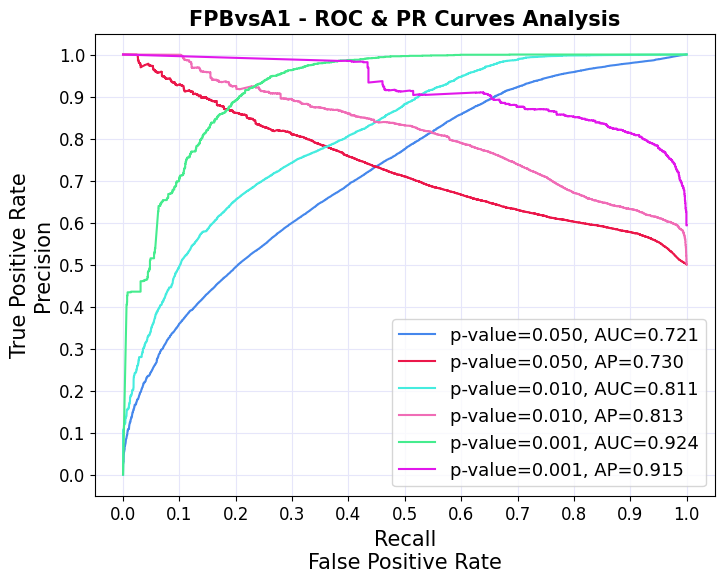

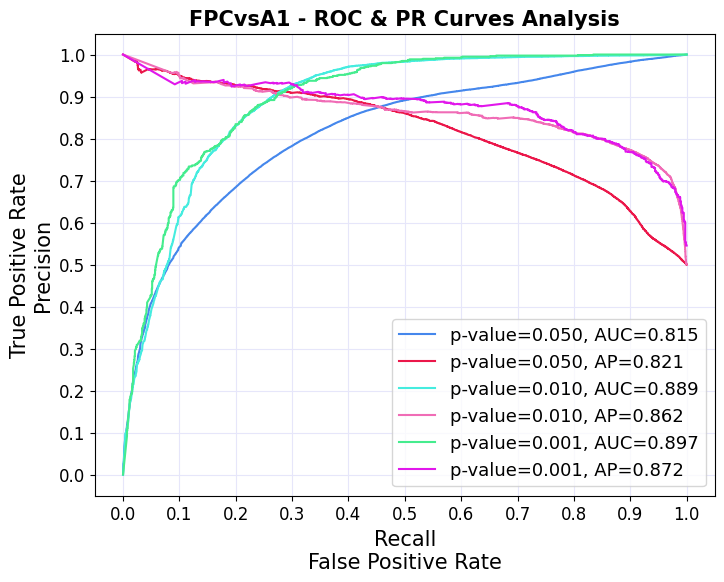

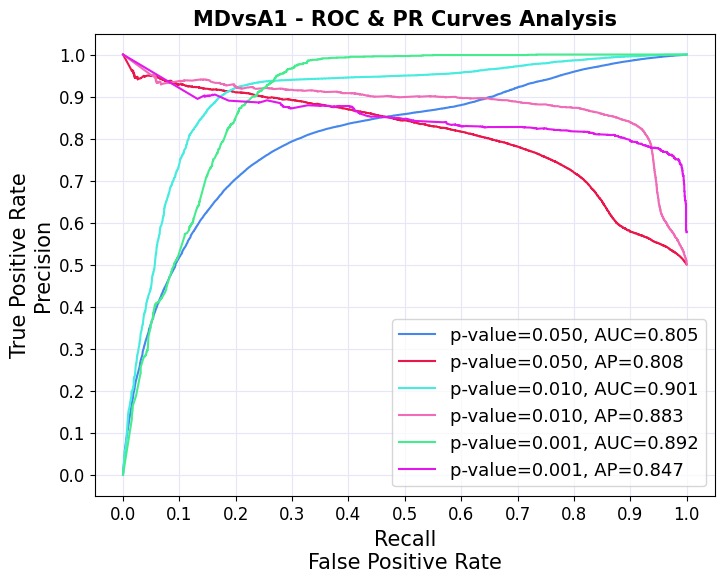

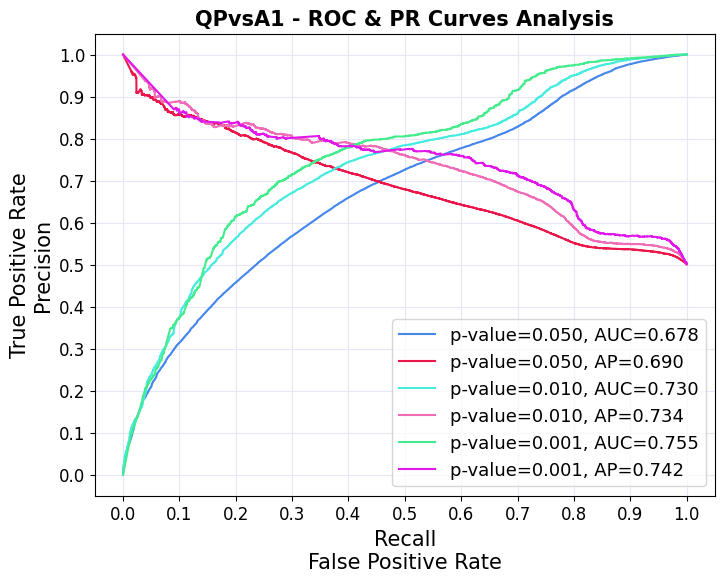

In [37]:
# plot diagnostics 
models = ['FPB', 'FPC', 'MD', 'QP']
colors1 = ["#4587ec", "#45ecdf", "#45ec8e"]
colors2 = ["#eb174a", "#f06cb6", "#e117eb"]

# figure
for i, diag in enumerate(diagnostic_res):
    fig = plt.figure(figsize=(8,6))
    
    for j, pvalue_thr_nn in enumerate(diag.keys()):
        
        # auc
        plt.plot(diag[pvalue_thr_nn]['fpr'], 
                 diag[pvalue_thr_nn]['tpr'], 
                 color = colors1[j],
                 label="p-value={:.3f}, AUC={:.3f}".format(pvalue_thr_nn, diag[pvalue_thr_nn]['auc']))
        
        # ap 
        plt.plot(diag[pvalue_thr_nn]['recall'], 
                 diag[pvalue_thr_nn]['precision'], 
                 color = colors2[j], 
                 label="p-value={:.3f}, AP={:.3f}".format(pvalue_thr_nn, diag[pvalue_thr_nn]['average_precision_score']))
    
    # legend 
    plt.legend(prop={'size':13}, loc='lower right')

    # title 
    plt.title(models[i] + 'vsA1 - ROC & PR Curves Analysis', fontweight='bold', fontsize=15)

    # x ticks
    plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize=12)
    plt.xlabel("Recall\nFalse Positive Rate", fontsize=15)

    # y ticks 
    plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=12)
    plt.ylabel("True Positive Rate\nPrecision", fontsize=15)

    # grid
    plt.grid(zorder=0, color='lavender')

    # save
    plt.savefig(output_path + '/ROC_PR_'+models[i]+'vsA1.png', bbox_inches='tight', dpi=600)

    plt.show()